In [1]:
import shapely
import pandas as pd
from shapely.geometry import LineString
import osmnx as ox
import geopandas as gpd
from numpy.linalg import norm
import numpy as np
import math
from matplotlib import pyplot as plt
import contextily as cx
from pyproj.crs import CRS
import scipy
from datetime import timedelta

from shapely.ops import linemerge

import route2vel
import route2vel.utils as utils
from route2vel.loading import load_graph
import route2vel
from notebookutils import *

from route2vel.interp import *
from route2vel.route import *
from route2vel.classes import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plt.style.use('dark_background')
route2vel.load_config("../..")

In [4]:
route_steps = ["Zola Predosa", "Castel San Pietro Terme"]

In [5]:
direction = find_route_osrm(route_steps, load_graph=True, load_graph_name='test_route_1')

[WARN] Creating direction without a priori graph information, this is not recommended currently as it will likely lead to redownloading the graph each run after doing so.
Loading graph from D:\Documenti\Universita\tesim\resources\graph\test_route_1.graphnx.pickle ...
Loaded in 0.34s!


In [6]:
print(f"Route length: {len(direction.geometry)} (osm nodes: {len(direction.nodelist())})")

Route length: 28 (osm nodes: 63)


In [7]:
nodes, edges = ox.graph_to_gdfs(direction.graph)

In [8]:
# direction.plot()

In [9]:
nodes

,y,x,street_count,elevation,highway,ref,geometry
osmid,,,,,,,
6714648,44.524136,11.293704,3,34.0,NaN,NaN,POINT (11.29370 44.52414)
6714672,44.516538,11.375632,3,28.0,motorway_junction,NaN,POINT (11.37563 44.51654)
31528061,44.401839,11.262877,2,91.0,NaN,NaN,POINT (11.26288 44.40184)
32200353,44.480668,11.433258,3,45.0,motorway_junction,NaN,POINT (11.43326 44.48067)
32200499,44.488230,11.267845,3,55.0,NaN,NaN,POINT (11.26784 44.48823)
...,...,...,...,...,...,...,...
11010047167,44.527212,11.272189,2,30.0,NaN,NaN,POINT (11.27219 44.52721)
11010047173,44.527364,11.272854,3,33.0,NaN,NaN,POINT (11.27285 44.52736)
11010047176,44.527415,11.273008,3,34.0,NaN,NaN,POINT (11.27301 44.52742)


In [10]:
direction.calc_gdf(node_gdf=nodes, rich_elevation=False)
direction.gdf.columns

Index(['u', 'v', 'key', 'osmid', 'name', 'highway', 'oneway', 'reversed',
       'length', 'geometry', 'grade', 'grade_abs', 'speed_kph', 'travel_time',
       'lanes', 'maxspeed', 'ref', 'bridge', 'junction', 'u_elevation',
       'v_elevation'],
      dtype='object')

In [11]:
direction.gdf

,u,v,key,osmid,name,highway,oneway,reversed,length,geometry,...,grade_abs,speed_kph,travel_time,lanes,maxspeed,ref,bridge,junction,u_elevation,v_elevation
0,1232505111,2157317040,0,35028723,Via Risorgimento,secondary,False,True,17.142,"LINESTRING (11.21962 44.49088, 11.21983 44.49084)",...,0.058,90.0,0.7,NaN,NaN,SP569R,NaN,NaN,80.0,81.0
1,2157317040,1282818263,0,35028723,Via Risorgimento,secondary,False,True,36.508,"LINESTRING (11.21983 44.49084, 11.21993 44.490...",...,0.055,90.0,1.5,NaN,NaN,SP569R,NaN,NaN,81.0,79.0
2,1282818263,294149931,0,"[107202425, 1122798874, 35028723]",Via Risorgimento,secondary,False,True,119.127,"LINESTRING (11.22028 44.49078, 11.22070 44.490...",...,0.017,90.0,4.8,2,NaN,SP569R,yes,NaN,79.0,77.0
3,294149931,1426791897,0,79982521,Via Risorgimento,secondary,False,True,102.648,"LINESTRING (11.22176 44.49058, 11.22193 44.490...",...,0.010,90.0,4.1,NaN,NaN,SP569R,NaN,NaN,77.0,78.0
4,1426791897,5143086671,0,79982521,Via Risorgimento,secondary,False,True,123.070,"LINESTRING (11.22280 44.49004, 11.22332 44.489...",...,0.041,90.0,4.9,NaN,NaN,SP569R,NaN,NaN,78.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1305533884,370327835,0,27417230,Via San Carlo,secondary,True,False,93.525,"LINESTRING (11.58715 44.40384, 11.58695 44.403...",...,0.096,90.0,3.7,NaN,NaN,NaN,NaN,NaN,69.0,60.0
58,370327835,355594174,0,31765971,Viale Roma,unclassified,True,False,45.518,"LINESTRING (11.58692 44.40301, 11.58679 44.40261)",...,0.088,70.0,2.3,NaN,NaN,NaN,NaN,NaN,60.0,64.0
59,355594174,361095915,0,150351209,Viale Roma,unclassified,True,False,10.007,"LINESTRING (11.58679 44.40261, 11.58683 44.40253)",...,0.000,70.0,0.5,NaN,NaN,NaN,NaN,NaN,64.0,64.0
60,361095915,361096035,0,809610253,Via Colombarina,residential,True,False,126.777,"LINESTRING (11.58683 44.40253, 11.58679 44.402...",...,0.024,50.0,9.1,NaN,NaN,NaN,NaN,NaN,64.0,67.0


In [12]:
direction.calc_gdf(node_gdf=nodes, rich_elevation=True)
direction.gdf.columns

Index(['u', 'v', 'key', 'osmid', 'name', 'highway', 'oneway', 'reversed',
       'length', 'geometry', 'grade', 'grade_abs', 'speed_kph', 'travel_time',
       'lanes', 'maxspeed', 'ref', 'bridge', 'junction', 'u_elevation',
       'v_elevation', 'geometry2d'],
      dtype='object')

In [13]:
list(direction.gdf["geometry"][1].coords)

[(11.2198327, 44.4908431, 81.0),
 (11.2199282, 44.4908252, 80.57392180494966),
 (11.2199542, 44.4908203, 80.45789983024869),
 (11.2202844, 44.4907816, 79.0)]

In [14]:
print(direction.gdf.loc[1, "geometry2d"])
print(len(direction.gdf.loc[1, "geometry2d"].coords))

LINESTRING (11.2198327 44.4908431, 11.2199282 44.4908252, 11.2199542 44.4908203, 11.2202844 44.4907816)
4


In [16]:
# test lerp modes
l = np.array([(x, 0) for x in [0, 1, 2, 100]])
print(linear_interpolation_polyline(l, 0.5))
print(linear_interpolation_polyline(l, 0.5, by_length=False))
print(linear_interpolation_polyline(l, np.array([0.25, 0.5])))
print(linear_interpolation_polyline(l, np.array([0.25, 0.5]), by_length=False))

[50.  0.]
[1.5 0. ]
[[25.  0.]
 [50.  0.]]
[[0.75 0.  ]
 [1.5  0.  ]]


In [17]:
print(linear_interpolation_polyline(l[:, 0:1], 0.5))
print(linear_interpolation_polyline(l[:, 0:1], 0.5, by_length=False))
print(linear_interpolation_polyline(l[:, 0:1], np.array([0.25, 0.5])))
print(linear_interpolation_polyline(l[:, 0:1], np.array([0.25, 0.5]), by_length=False))

[50.]
[1.5]
[[25.]
 [50.]]
[[0.75]
 [1.5 ]]


In [22]:
interp_dir = interp_from_route(direction)

for i in [1, 2]:
    print(f"== Index: {i} Base Index: {interp_dir.split_gdf.loc[i, 'base_idx']}")
    print(len(interp_dir.split_gdf.loc[i, "geometry"].coords), interp_dir.split_gdf.loc[i, "geometry"])
    print(len(interp_dir.split_gdf.loc[i, "geometry2d"].coords), interp_dir.split_gdf.loc[i, "geometry2d"])

== Index: 1 Base Index: 1
3 LINESTRING Z (11.2198327 44.4908431 81, 11.2199282 44.4908252 80.57392180494966, 11.2199542 44.4908203 80.45789983024869)
3 LINESTRING (11.2198327 44.4908431, 11.2199282 44.4908252, 11.2199542 44.4908203)
== Index: 2 Base Index: 1
2 LINESTRING Z (11.2199542 44.4908203 80.45789983024869, 11.2202844 44.4907816 79)
2 LINESTRING (11.2199542 44.4908203, 11.2202844 44.4907816)


In [60]:
meters_density = 0.1
pt_num = interp_dir.pt_num_for_density(meters_density)
print(f"For meters density {meters_density}m using {pt_num} points")

For meters density 0.1m using 430320 points


In [61]:
plot_gdf = interp_dir.get_gdf_to_plot(pt_num, continuous_lines=True)

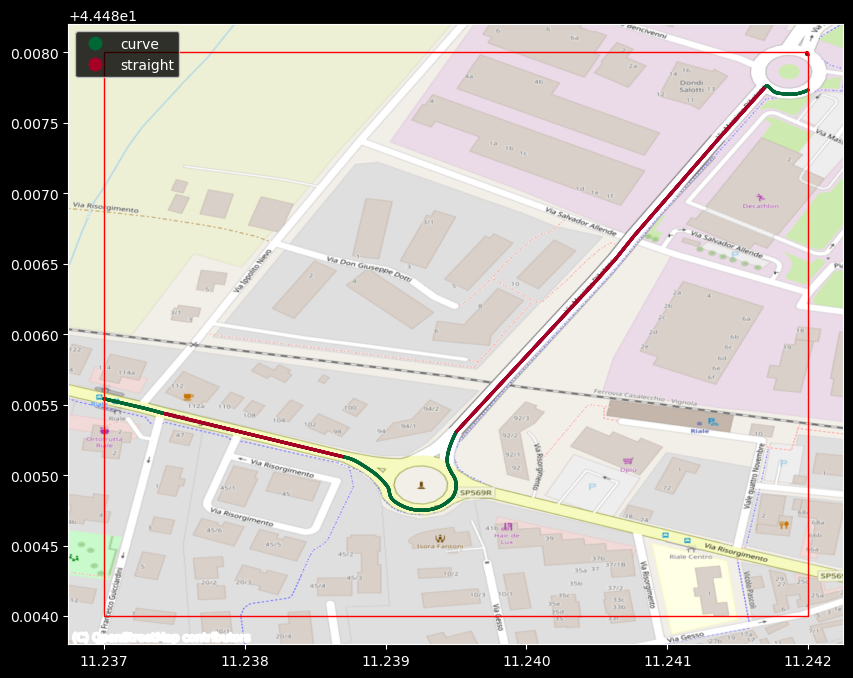

c:\Users\fillo\anaconda3\envs\ox\Lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


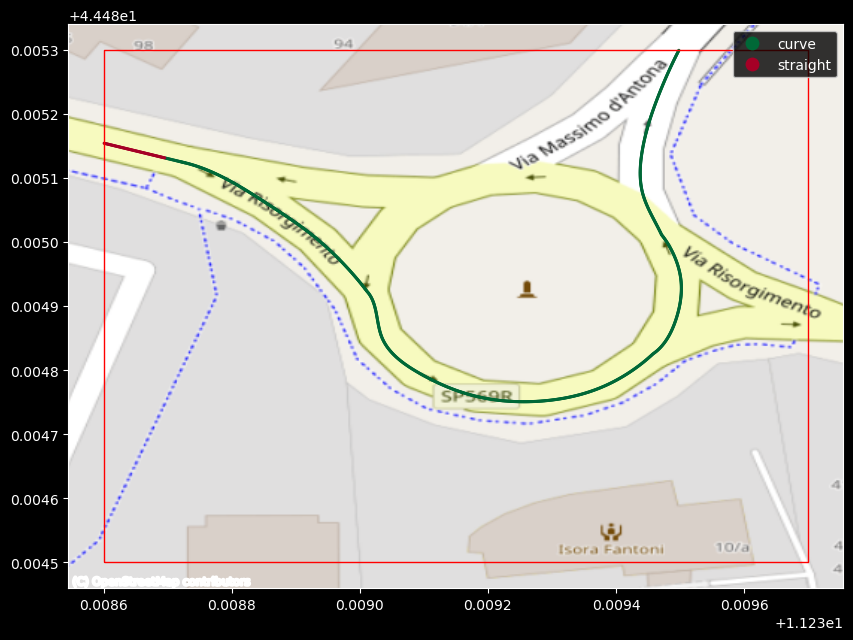

In [62]:
interesting_bound_set = [
    ((11.237, 44.484), (11.242, 44.488)),
    ((11.2386, 44.4845), (11.2397, 44.4853)),
]

for bounds in interesting_bound_set:
    display_bounded_shapes([
        # (route_interp_gdf, {'column': 'curve', 'categorical':True, 'legend':True, 'cmap':'RdYlGn_r'}),
        (plot_gdf, {'column': 'curve', 'categorical':True, 'legend':True, 'cmap':'RdYlGn_r', 's': 1.5}),
    ], *bounds, crs=plot_gdf.crs);

In [63]:
# Use 3d coord when making bezier
plot_gdf = interp_dir.get_gdf_to_plot(pt_num, continuous_lines=True, geom_key="geometry")
plot_gdf["z"] = plot_gdf["geometry"].apply(lambda x: x.z)

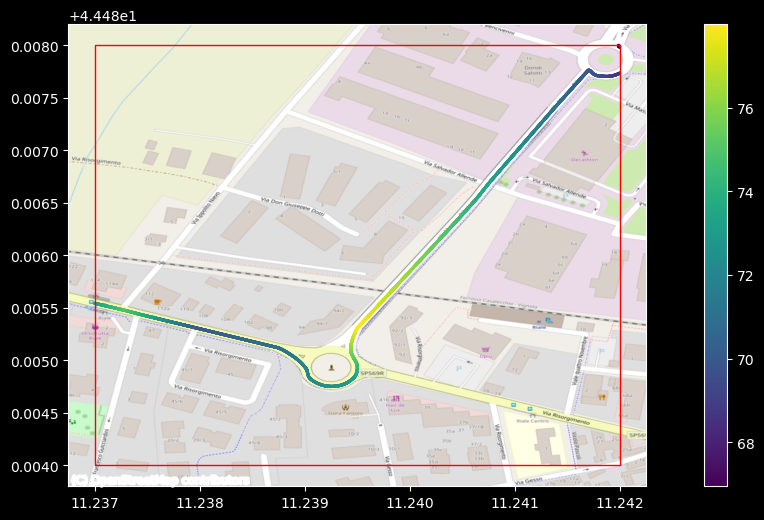

c:\Users\fillo\anaconda3\envs\ox\Lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


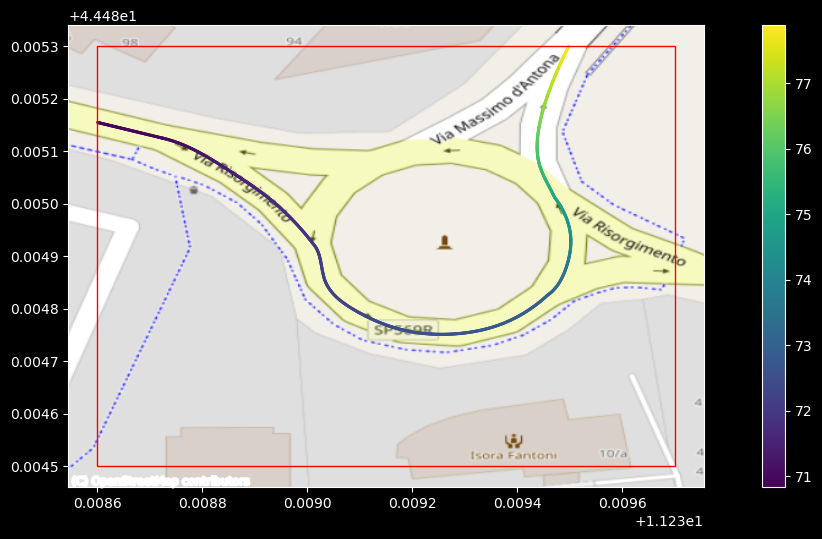

In [64]:
interesting_bound_set = [
    ((11.237, 44.484), (11.242, 44.488)),
    ((11.2386, 44.4845), (11.2397, 44.4853)),
]

for bounds in interesting_bound_set:
    display_bounded_shapes([
        # (route_interp_gdf, {'column': 'curve', 'categorical':True, 'legend':True, 'cmap':'RdYlGn_r'}),
        (plot_gdf, {'column': 'z', 'legend':True, 's': 1.5}),
    ], *bounds, crs=plot_gdf.crs, figsize=(15, 6));